In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy.stats.mstats import winsorize
#from __future__ import division, print_function
from builtins import reversed
from builtins import map, zip
from collections.abc import MutableSequence, Sequence
import copy
from math import ceil
from numbers import Complex, Integral, Real
import sys
import warnings
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import kendalltau
import cvxpy as cp
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import rankdata

### **3) Risk-based portfolios:** 
(a) Using your favourite covariance matrix estimator from Question 2), create the following portfolios, both at datePP as well as at dateTr, under basic non-negativity constraints wi ≥0, ∀i, and full allocation and leverage constraints 1′w = 1: \
i. The minimum variance portfolio, \
ii. The equal risk contribution portfolio (see Roncalli, 2009),\
iii. The maximum effective number of bets portfolio of Meucci (2009),\
iv. The hierarchical risk parity portfolio of Lopez De Prado (2016).

i. The minimum variance portfolio : 

The minimum‐variance portfolio (MVP) weights $w^*$ solve
$$
\begin{aligned}
w^* \;=\;&\underset{w\in\mathbb{R}^N}{\arg\min}\; w^\top \Sigma\,w\\
\text{s.t.}\quad &w_i \;\ge0,\quad i=1,\dots,N,\\
&\sum_{i=1}^N w_i \;=\;1.
\end{aligned}
$$

In [25]:
def min_variance_portfolio(cov_matrix: np.ndarray) :
    n = cov_matrix.shape[0]
    # Define variable
    w = cp.Variable(n)
    # Objective: minimize portfolio variance w' Σ w
    objective = cp.Minimize(cp.quad_form(w, cov_matrix))
    # Constraints: non-negativity and full allocation
    constraints = [w >= 0, cp.sum(w) == 1]
    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK, verbose=False)

    if prob.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        raise ValueError(f"Optimization failed with status {prob.status}")

    return w.value


MVP_weights_PP = min_variance_portfolio(cov_PP_clean)
MVP_weights_Tr = min_variance_portfolio(cov_Tr_clean)
print("Minimum variance portfolio weights at datePP:")
print(pd.Series(MVP_weights_PP , index=cov_PP.columns).to_string(float_format='{:,.6f}'.format))
print("\nMinimum Variance Portfolio weights at dateTr:")
print(pd.Series(MVP_weights_Tr, index=cov_PP.columns).to_string(float_format='{:,.6f}'.format))

Minimum variance portfolio weights at datePP:
ADA-USD    0.000069
BCH-USD    0.000078
BTC-USD    0.000113
DOGE-USD   0.000063
ETH-USD    0.000088
LINK-USD   0.000070
LTC-USD    0.000084
MANA-USD   0.000066
XLM-USD    0.000071
XRP-USD    0.000071
SPXT       0.001866
XCMP       0.001300
SOFR       0.995575
VIX        0.000486

Minimum Variance Portfolio weights at dateTr:
ADA-USD    0.000119
BCH-USD    0.000131
BTC-USD    0.000184
DOGE-USD   0.000121
ETH-USD    0.000139
LINK-USD   0.000112
LTC-USD    0.000136
MANA-USD   0.000110
XLM-USD    0.000139
XRP-USD    0.000135
SPXT       0.000945
XCMP       0.000653
SOFR       0.996299
VIX        0.000778


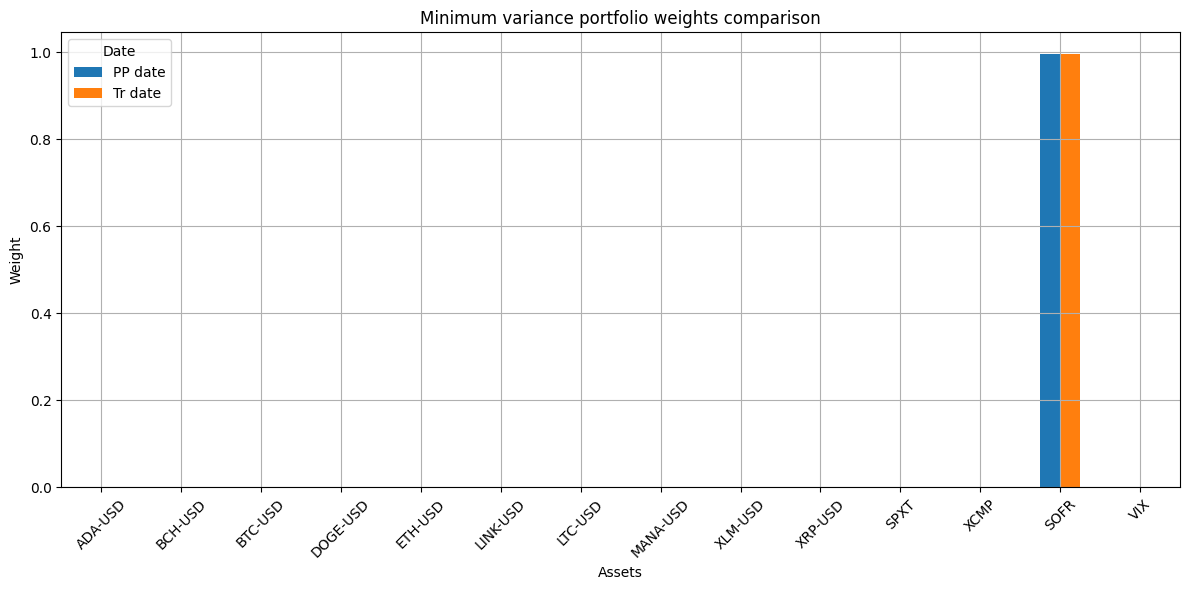

In [26]:
weights_PP = pd.Series(MVP_weights_PP, index=cov_PP.columns, name='PP date')
weights_Tr = pd.Series(MVP_weights_Tr, index=cov_PP.columns, name='Tr date')
weights_df = pd.concat([weights_PP, weights_Tr], axis=1)

# Plot
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title("Minimum variance portfolio weights comparison")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Date")
plt.tight_layout()
plt.grid(True)
plt.show()

In [27]:
rets_sans_sofr = rets.drop(columns=["SOFR"])

datePP = pd.Timestamp('2021-09-11')
dateTr = pd.Timestamp('2022-11-21')
window = 252  # days in window

# extract rolling windows ending on each date
rets_PP_sofr = rets_sans_sofr.loc[:datePP].iloc[-window:]
rets_Tr_sofr = rets_sans_sofr.loc[:dateTr].iloc[-window:]

# compute sample covariance matrices
cov_PP_sofr = rets_PP_sofr.cov()
cov_Tr_sofr = rets_Tr_sofr.cov()

cov_PP_clean_sofr = clipped(rets_PP_sofr)
cov_Tr_clean_sofr = clipped(rets_Tr_sofr)



MVP_weights_PP_sofr = min_variance_portfolio(cov_PP_clean_sofr)
MVP_weights_Tr_sofr = min_variance_portfolio(cov_Tr_clean_sofr)
print("Minimum variance portfolio weights at datePP:")
print(pd.Series(MVP_weights_PP_sofr , index=cov_PP_sofr.columns).to_string(float_format='{:,.6f}'.format))
print("\nMinimum Variance Portfolio weights at dateTr:")
print(pd.Series(MVP_weights_Tr_sofr, index=cov_PP_sofr.columns).to_string(float_format='{:,.6f}'.format))


Minimum variance portfolio weights at datePP:
ADA-USD    0.000009
BCH-USD    0.001230
BTC-USD    0.003753
DOGE-USD   0.000019
ETH-USD    0.000450
LINK-USD   0.000042
LTC-USD    0.001015
MANA-USD   0.000004
XLM-USD    0.000011
XRP-USD    0.000006
SPXT       0.671297
XCMP       0.236739
VIX        0.085425

Minimum Variance Portfolio weights at dateTr:
ADA-USD    0.000001
BCH-USD    0.000002
BTC-USD    0.003712
DOGE-USD   0.000001
ETH-USD    0.000001
LINK-USD   0.000001
LTC-USD    0.000002
MANA-USD   0.000001
XLM-USD    0.000003
XRP-USD    0.000009
SPXT       0.611345
XCMP       0.224635
VIX        0.160287


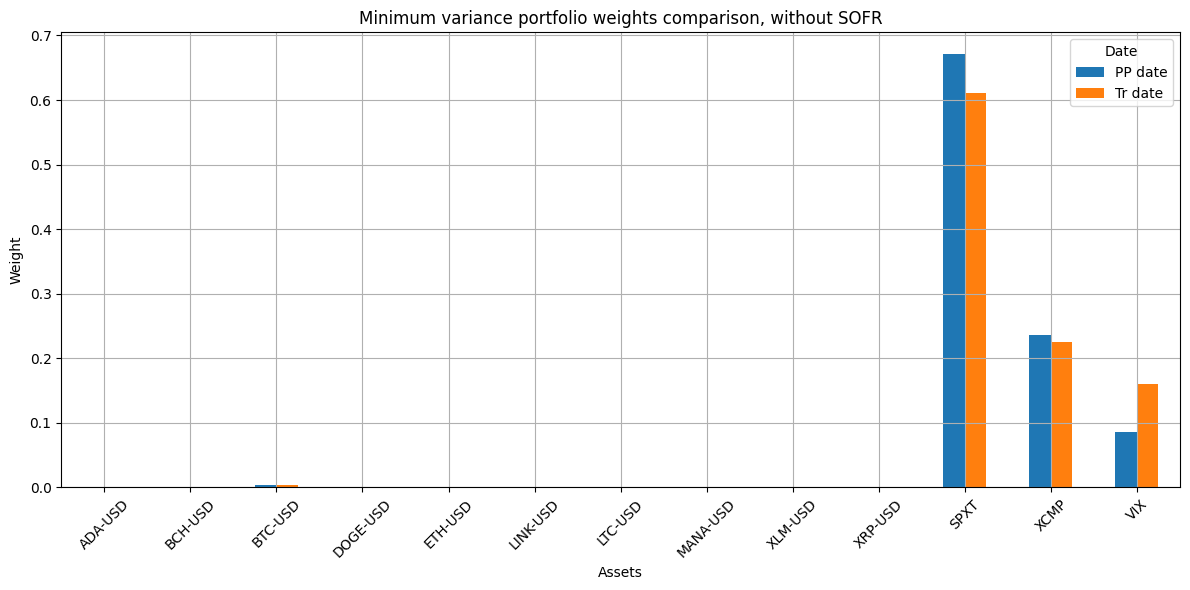

In [28]:
weights_PP = pd.Series(MVP_weights_PP_sofr, index=cov_PP_sofr.columns, name='PP date')
weights_Tr = pd.Series(MVP_weights_Tr_sofr, index=cov_PP_sofr.columns, name='Tr date')
weights_df = pd.concat([weights_PP, weights_Tr], axis=1)

# Plot
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title("Minimum variance portfolio weights comparison, without SOFR")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Date")
plt.tight_layout()
plt.grid(True)
plt.show()

ii. The equal risk contribution portfolio (see Roncalli, 2009) :

The Equal Risk Contribution (ERC) portfolio aims to equalize the individual asset contributions to total portfolio risk.

Let $\mathbf{w} \in \mathbb{R}^n$ be the vector of portfolio weights,  $\boldsymbol{\Sigma} \in \mathbb{R}^{n \times n}$ be the covariance matrix of asset returns,$\sigma_p = \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}$ be the total portfolio volatility.


The marginal risk contribution (MRC) of asset  $i$ is:
$\text{MRC}_i = \frac{\partial \sigma_p}{\partial w_i} = \frac{(\boldsymbol{\Sigma} \mathbf{w})_i}{\sigma_p}$

The total risk contribution (RC) of asset $i$ is:
$\text{RC}_i = w_i \cdot \text{MRC}_i = \frac{w_i (\boldsymbol{\Sigma} \mathbf{w})_i}{\sigma_p}$

The ERC portfolio solves:
$ \min_{\mathbf{w}} \sum_{i=1}^{n} \sum_{j=1}^{n} \left( w_i(\Sigma \mathbf{w})_i - w_i(\Sigma \mathbf{w})_j \right)^2$

Subject to:
$\sum_{i=1}^{n} w_i = 1$ , $w_i \geq 0 \quad \text{for all } i = 1, \ldots, n$


In [29]:
def _risk_contributions_norm(x, cov):
    # Euler risk contributions: RC_i = w_i * (Sigma w)_i / sqrt(w^T Sigma w)
    mw = cov.dot(x)
    sigma_p=np.sqrt(x.dot(mw))  # portfolio risk
    return x * mw / sigma_p


def _erc_objective(x, cov):
    # ERC objective: sum_{i,j} (RC_i - RC_j)^2
    rc = _risk_contributions_norm(x, cov)
    # pairwise differences
    diff = rc[:, None] - rc[None, :]
    return np.sum(diff**2)


def equal_risk_contribution(cov, initial=None, tol=1e-9):
   # minimize sum_{i,j}(RC_i - RC_j)^2 subject to sum(w)=1, w>=0
    n = cov.shape[0]
    if initial is None:
        initial = np.ones(n) / n

    bounds = [(0.0, 1.0)] * n
    constraints = ({ 'type': 'eq', 'fun': lambda w: np.sum(w) - 1 },)

    result = minimize(
        _erc_objective,
        initial,
        args=(cov,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': tol, 'disp': False}
    )

    if not result.success:
        raise RuntimeError("ERC optimization failed: " + result.message)

    return result.x


ERC_weights_PP = equal_risk_contribution(cov_PP_clean)
ERC_weights_Tr = equal_risk_contribution(cov_Tr_clean)
print("Equal risk contribution portfolio weights at datePP:")
print(pd.Series(ERC_weights_PP , index=cov_PP.columns).to_string(float_format='{:,.6f}'.format))
print("\nEqual risk contribution portfolio weights at dateTr:")
print(pd.Series(ERC_weights_Tr, index=cov_PP.columns).to_string(float_format='{:,.6f}'.format))


Equal risk contribution portfolio weights at datePP:
ADA-USD    0.000028
BCH-USD    0.000040
BTC-USD    0.000047
DOGE-USD   0.000015
ETH-USD    0.000044
LINK-USD   0.000027
LTC-USD    0.000040
MANA-USD   0.000019
XLM-USD    0.000048
XRP-USD    0.000040
SPXT       0.001107
XCMP       0.000000
SOFR       0.998305
VIX        0.000239

Equal risk contribution portfolio weights at dateTr:
ADA-USD    0.000322
BCH-USD    0.000288
BTC-USD    0.000456
DOGE-USD   0.000370
ETH-USD    0.000334
LINK-USD   0.000349
LTC-USD    0.000431
MANA-USD   0.000280
XLM-USD    0.000284
XRP-USD    0.000473
SPXT       0.001469
XCMP       0.001070
SOFR       0.993874
VIX        0.000000


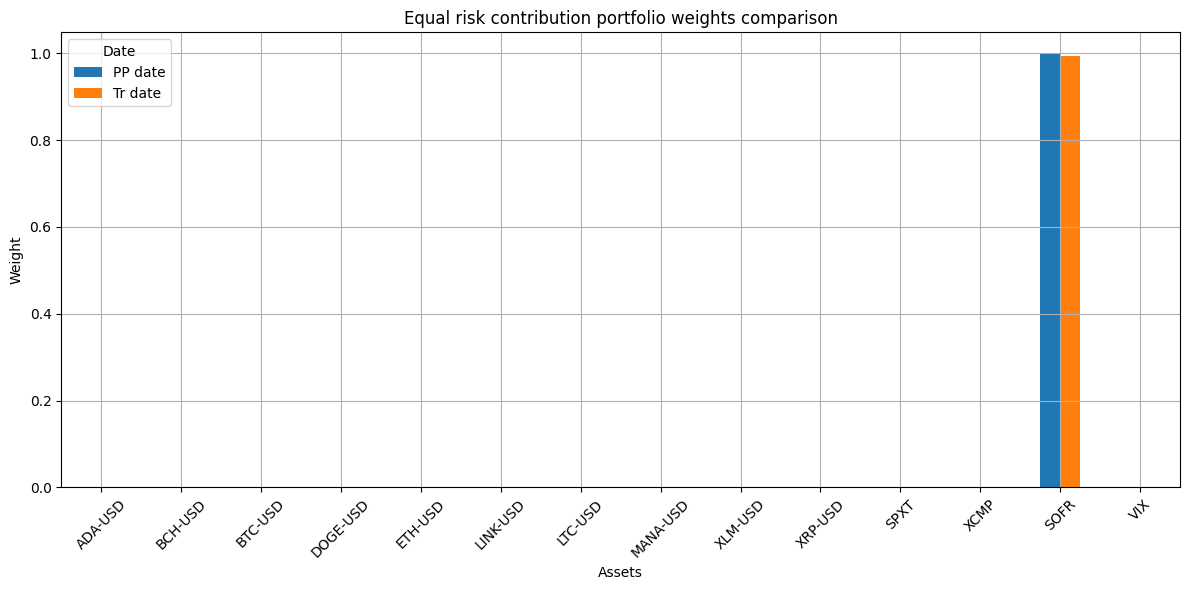

In [30]:
weights_PP = pd.Series(ERC_weights_PP, index=cov_PP.columns, name='PP date')
weights_Tr = pd.Series(ERC_weights_Tr, index=cov_PP.columns, name='Tr date')
weights_df = pd.concat([weights_PP, weights_Tr], axis=1)

# Plot
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title("Equal risk contribution portfolio weights comparison")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Date")
plt.tight_layout()
plt.grid(True)
plt.show()

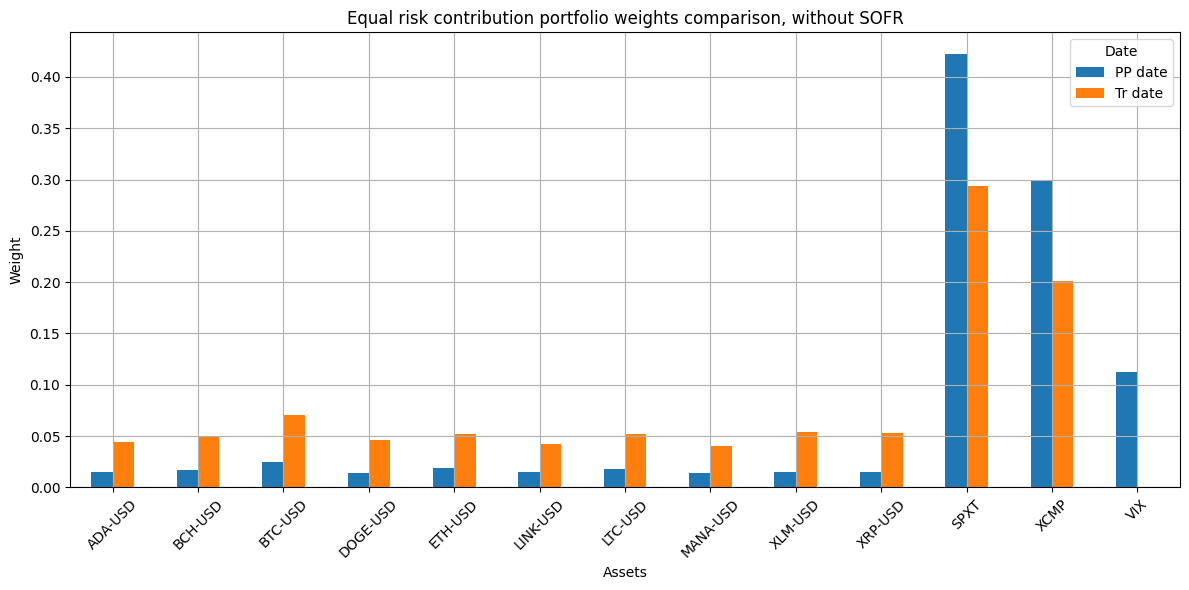

In [31]:
ERC_weights_PP_sofr = equal_risk_contribution(cov_PP_clean_sofr)
ERC_weights_Tr_sofr = equal_risk_contribution(cov_Tr_clean_sofr)

weights_PP = pd.Series(ERC_weights_PP_sofr, index=cov_PP_sofr.columns, name='PP date')
weights_Tr = pd.Series(ERC_weights_Tr_sofr, index=cov_PP_sofr.columns, name='Tr date')
weights_df = pd.concat([weights_PP, weights_Tr], axis=1)

# Plot
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title("Equal risk contribution portfolio weights comparison, without SOFR")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Date")
plt.tight_layout()
plt.grid(True)
plt.show()

iii. The maximum effective number of bets portfolio of Meucci (2009)

In [32]:
def effective_num_bets(w: np.ndarray, cov_matrix: np.ndarray):
    # eigen-decomposition
    lambdas, E = np.linalg.eigh(cov_matrix)
    idx = np.argsort(lambdas)[::-1]
    l = lambdas[idx]
    E = E[:, idx]
    # exposures to principal portfolios
    exposures = E.T @ w
    # scaled by volatilities
    g = np.sqrt(l) * exposures
    p = g**2 / (w @ cov_matrix @ w)
    p = np.clip(p, 0, None)
    p /= p.sum()
    # entropy
    H = -np.sum(p * np.log(p + 1e-16))
    return np.exp(H)


def max_effective_bets_portfolio(cov_matrix: np.ndarray,
                                 tol: float = 1e-8) -> np.ndarray:
    n = cov_matrix.shape[0]
    init = np.ones(n) / n
    bounds = [(0, 1)] * n
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
    def obj(x):
        return -effective_num_bets(x, cov_matrix)
    result = minimize(obj, init, method='SLSQP', bounds=bounds, constraints=cons)
    if not result.success:
        raise RuntimeError("Max-effective-bets optimization failed: " + result.message)
    w = np.maximum(result.x, 0)
    return w / np.sum(w)


ENB_weights_PP = max_effective_bets_portfolio(cov_PP_clean)
ENB_weights_Tr = max_effective_bets_portfolio(cov_Tr_clean)
print("Maximum effective number of bets portfolio weights at datePP:")
print(pd.Series(ENB_weights_PP , index=cov_PP.columns).to_string(float_format='{:,.6f}'.format))
print("Maximum effective number of bets portfolio weights at dateTr:")
print(pd.Series(ENB_weights_Tr, index=cov_PP.columns).to_string(float_format='{:,.6f}'.format))


Maximum effective number of bets portfolio weights at datePP:
ADA-USD    0.020016
BCH-USD    0.000000
BTC-USD    0.000000
DOGE-USD   0.000000
ETH-USD    0.000000
LINK-USD   0.000000
LTC-USD    0.000000
MANA-USD   0.000000
XLM-USD    0.000000
XRP-USD    0.112602
SPXT       0.000000
XCMP       0.665928
SOFR       0.027572
VIX        0.173882
Maximum effective number of bets portfolio weights at dateTr:
ADA-USD    0.000000
BCH-USD    0.000000
BTC-USD    0.000000
DOGE-USD   0.000000
ETH-USD    0.003194
LINK-USD   0.000000
LTC-USD    0.000011
MANA-USD   0.000000
XLM-USD    0.000000
XRP-USD    0.000000
SPXT       0.010169
XCMP       0.000000
SOFR       0.983535
VIX        0.003090


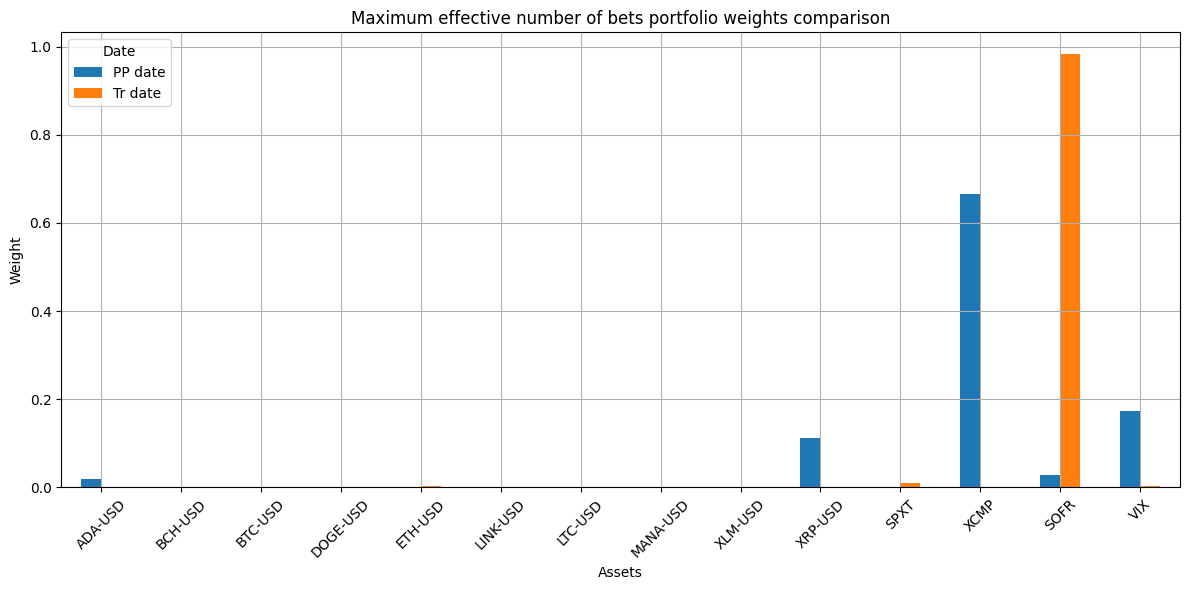

In [33]:
weights_PP = pd.Series(ENB_weights_PP, index=cov_PP.columns, name='PP date')
weights_Tr = pd.Series(ENB_weights_Tr, index=cov_PP.columns, name='Tr date')
weights_df = pd.concat([weights_PP, weights_Tr], axis=1)

# Plot
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title("Maximum effective number of bets portfolio weights comparison")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Date")
plt.tight_layout()
plt.grid(True)
plt.show()

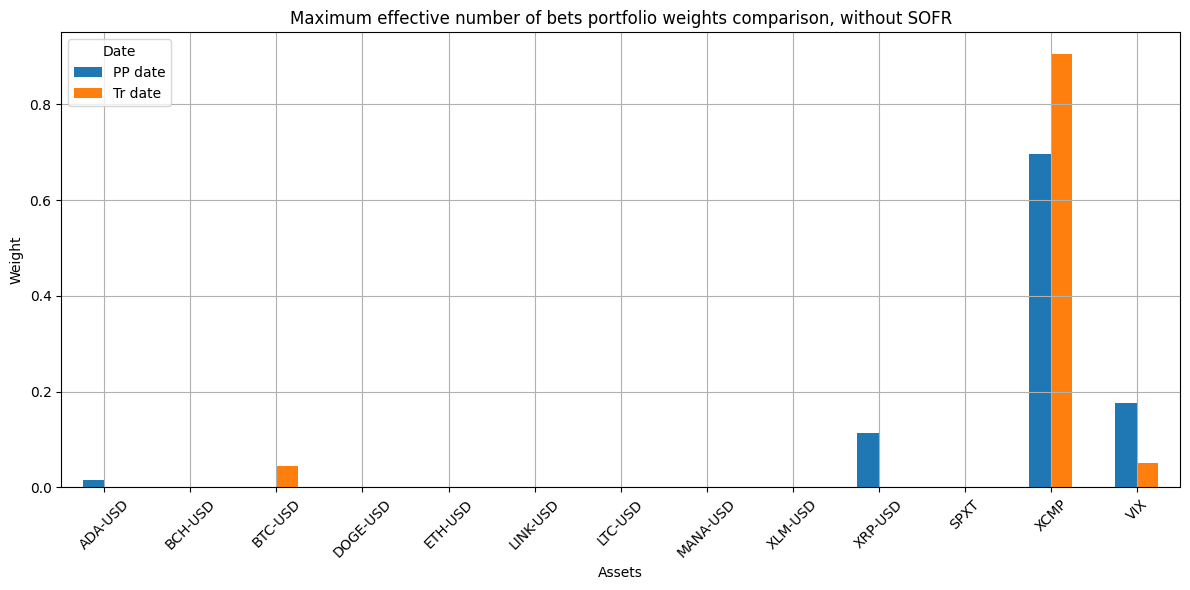

In [34]:
ENB_weights_PP_sofr = max_effective_bets_portfolio(cov_PP_clean_sofr)
ENB_weights_Tr_sofr = max_effective_bets_portfolio(cov_Tr_clean_sofr)

weights_PP = pd.Series(ENB_weights_PP_sofr, index=cov_PP_sofr.columns, name='PP date')
weights_Tr = pd.Series(ENB_weights_Tr_sofr, index=cov_PP_sofr.columns, name='Tr date')
weights_df = pd.concat([weights_PP, weights_Tr], axis=1)

# Plot
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title("Maximum effective number of bets portfolio weights comparison, without SOFR")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Date")
plt.tight_layout()
plt.grid(True)
plt.show()


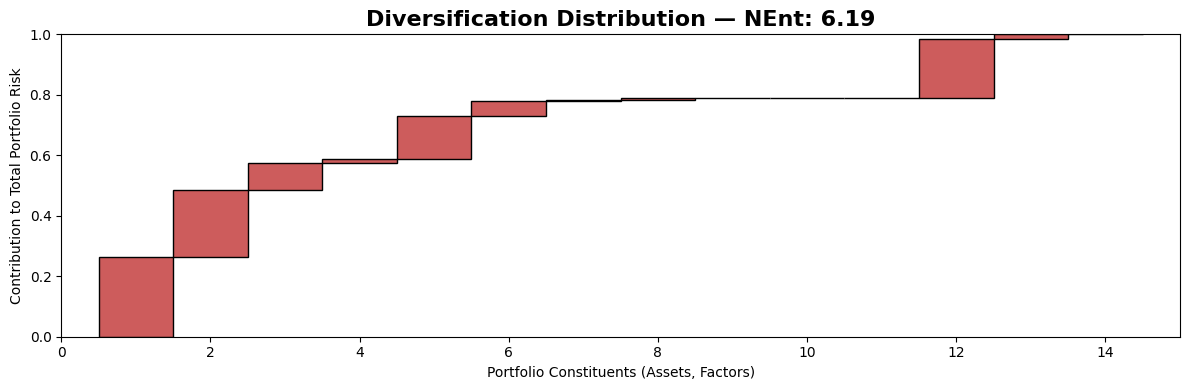

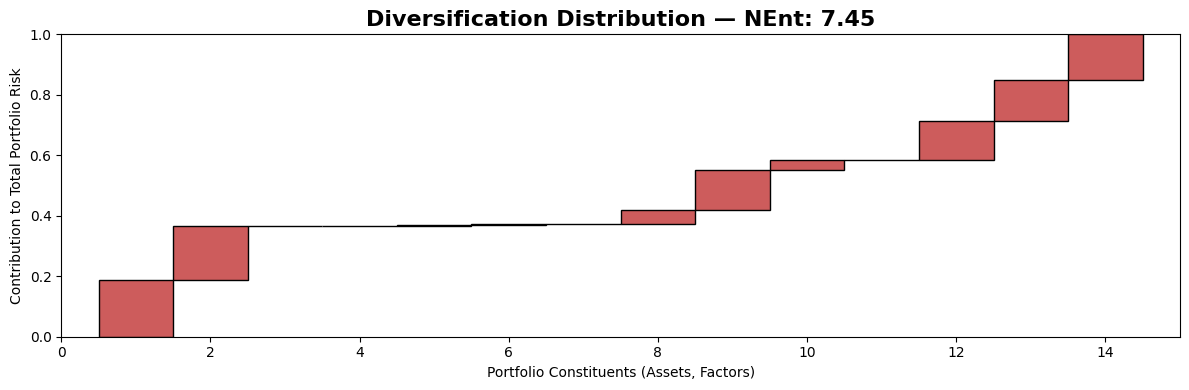

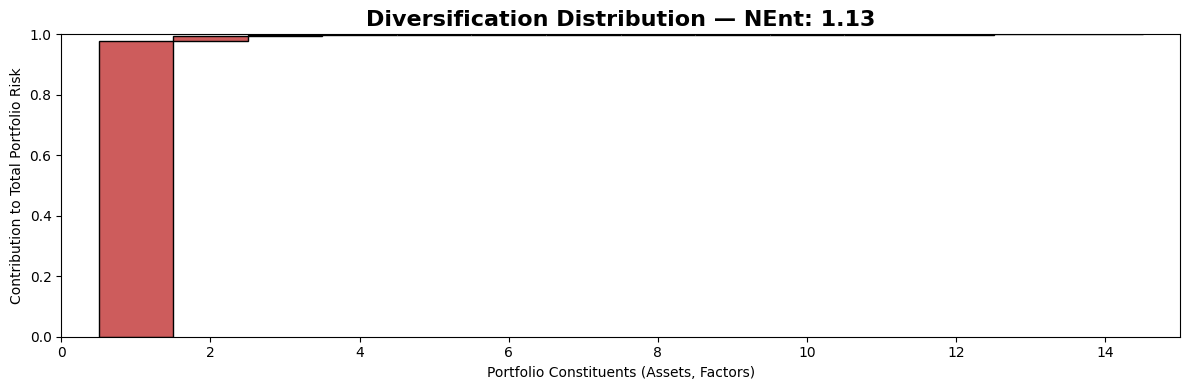

In [35]:
def plot_diversification_distribution(weights,cov,n_asset): 
       n = n_asset
       p = diversification_distribution(cov,weights)
       num_bets = effective_num_bets(weights,cov)
       bottom = np.concatenate([[0], np.cumsum(p)[:-1]])
       # tracé
       fig, ax = plt.subplots(figsize=(12, 4))
       x = np.arange(1, n+1)
       ax.bar(x,                # position
       p,                # hauteur
       bottom=bottom,    # point de départ de chaque barre
       color='indianred',
       edgecolor='k',
       width=1.0)
       
       ax.set_xlim(0, n+1)
       ax.set_ylim(0, 1.0)
       ax.set_xlabel("Portfolio Constituents (Assets, Factors)")
       ax.set_ylabel("Contribution to Total Portfolio Risk")
       ax.set_title(f"Diversification Distribution — NEnt: {num_bets:.2f}", fontsize=16, fontweight='bold')
       plt.tight_layout()
       plt.show()


# PP date, with SOFR
plot_diversification_distribution(ENB_weights_PP,cov_PP_clean,14)
# Tr date, with SOFR
plot_diversification_distribution(ENB_weights_Tr,cov_Tr_clean,14)
# equally weighted portfolio
plot_diversification_distribution(w_PP,cov_PP_clean,14)

iv. The hierarchical risk parity portfolio of Lopez De Prado (2016)

In [36]:
def get_cluster_var(cov_matrix: np.ndarray, cluster: list):
    sub = cov_matrix[np.ix_(cluster, cluster)]
    inv_var = 1.0 / np.diag(sub)
    ivp = inv_var / inv_var.sum()
    return float(ivp.T.dot(sub).dot(ivp))


def get_quasi_diag(link: np.ndarray):
    link = link.astype(int)
    num_items = link[-1, 3]
    order = [link[-1, 0], link[-1, 1]]
    while any(item >= num_items for item in order):
        new_order = []
        for item in order:
            if item < num_items:
                new_order.append(item)
            else:
                idx = int(item - num_items)
                new_order.append(link[idx, 0])
                new_order.append(link[idx, 1])
        order = new_order
    return order


def get_rec_bipart(cov_matrix: np.ndarray, order: list):
    n = cov_matrix.shape[0]
    w = np.ones(n)
    clusters = [order]
    while clusters:
        next_clusters = []
        for cluster in clusters:
            if len(cluster) <= 1:
                continue
            k = len(cluster) // 2
            c1 = cluster[:k]
            c2 = cluster[k:]
            var1 = get_cluster_var(cov_matrix, c1)
            var2 = get_cluster_var(cov_matrix, c2)
            alpha = 1 - var1 / (var1 + var2)
            w[c1] *= alpha
            w[c2] *= (1 - alpha)
            next_clusters += [c1, c2]
        clusters = next_clusters
    return w


def hierarchical_risk_parity(cov_matrix: np.ndarray, method: str = 'single'):
    # 1) Convert covariance to correlation-based distance
    corr = cov_matrix / np.sqrt(np.outer(np.diag(cov_matrix), np.diag(cov_matrix)))
    dist = np.sqrt((1 - corr) / 2)
    # 2) Cluster
    dist_condensed = squareform(dist, checks=False)
    link = linkage(dist_condensed, method=method)
    # 3) Quasi-diagonalization
    order = get_quasi_diag(link)
    # 4) Recursive bisection
    w = get_rec_bipart(cov_matrix, order)
    return w / np.sum(w)


HRP_weights_PP = hierarchical_risk_parity(cov_PP_clean)
HRP_weights_Tr = hierarchical_risk_parity(cov_Tr_clean)
print("Hierarchical risk parity portfolio weights at datePP:")
print(pd.Series(HRP_weights_PP , index=cov_PP.columns).to_string(float_format='{:,.6f}'.format))
print("\nHierarchical risk parity portfolio weights at dateTr:")
print(pd.Series(HRP_weights_Tr, index=cov_PP.columns).to_string(float_format='{:,.6f}'.format))

Hierarchical risk parity portfolio weights at datePP:
ADA-USD    0.000000
BCH-USD    0.000000
BTC-USD    0.000000
DOGE-USD   0.000000
ETH-USD    0.000000
LINK-USD   0.000000
LTC-USD    0.000000
MANA-USD   0.000000
XLM-USD    0.000000
XRP-USD    0.000000
SPXT       0.000000
XCMP       0.000000
SOFR       1.000000
VIX        0.000000

Hierarchical risk parity portfolio weights at dateTr:
ADA-USD    0.000000
BCH-USD    0.000000
BTC-USD    0.000001
DOGE-USD   0.000001
ETH-USD    0.000000
LINK-USD   0.000001
LTC-USD    0.000000
MANA-USD   0.000001
XLM-USD    0.000000
XRP-USD    0.000001
SPXT       0.000033
XCMP       0.000010
SOFR       0.999950
VIX        0.000001


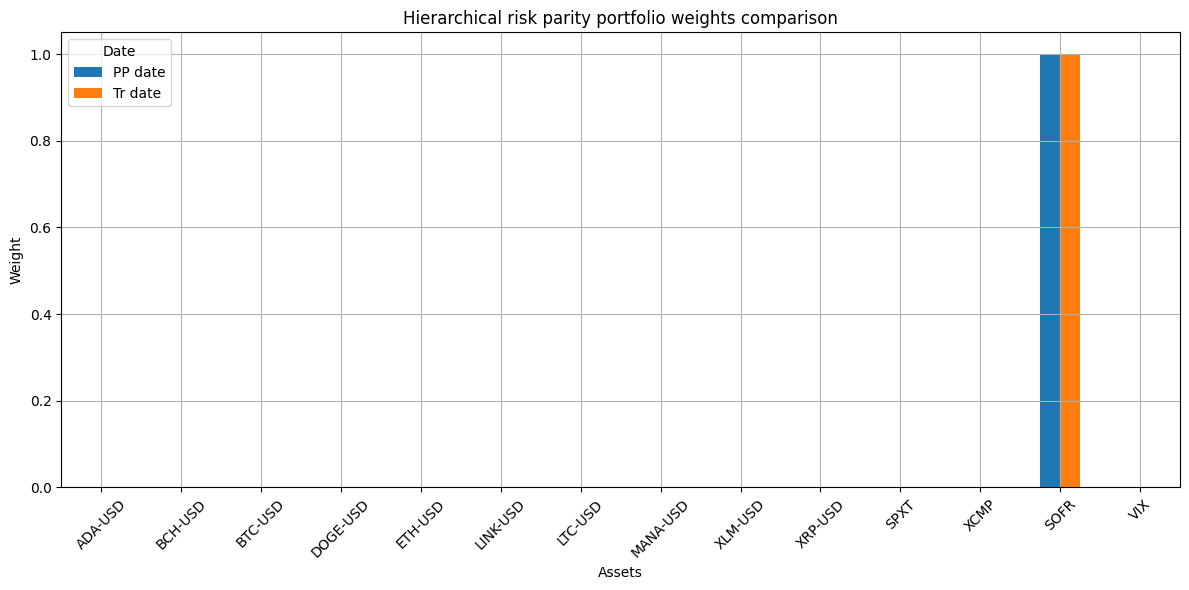

In [37]:
weights_PP = pd.Series(HRP_weights_PP, index=cov_PP.columns, name='PP date')
weights_Tr = pd.Series(HRP_weights_Tr, index=cov_PP.columns, name='Tr date')
weights_df = pd.concat([weights_PP, weights_Tr], axis=1)

# Plot
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title("Hierarchical risk parity portfolio weights comparison")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Date")
plt.tight_layout()
plt.grid(True)
plt.show()

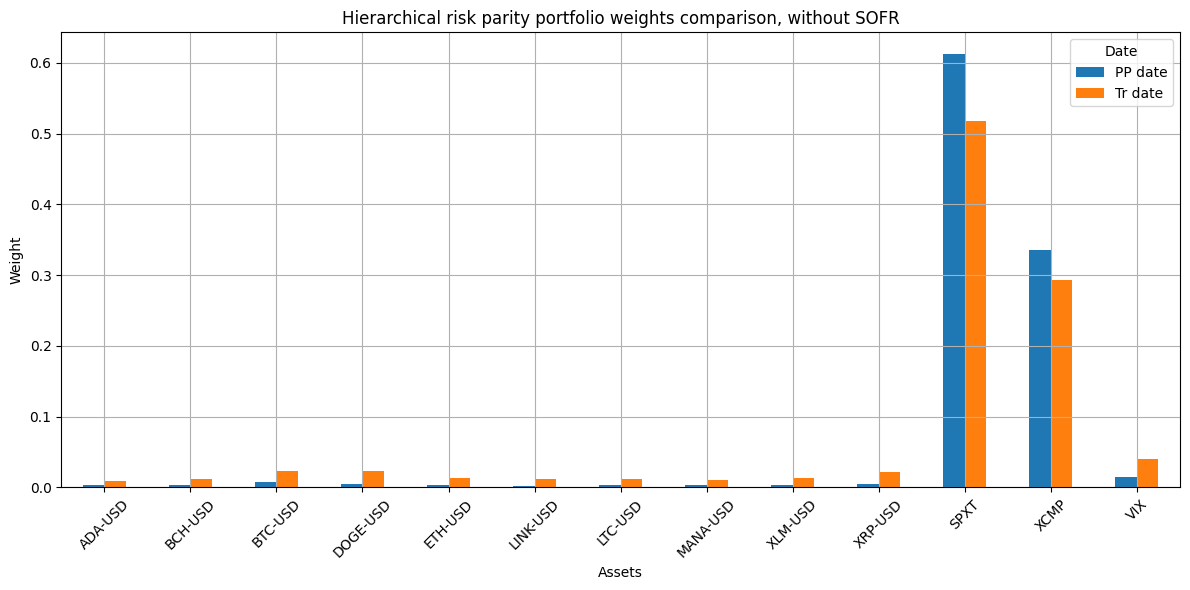

In [38]:
HRP_weights_PP_sofr = hierarchical_risk_parity(cov_PP_clean_sofr)
HRP_weights_Tr_sofr = hierarchical_risk_parity(cov_Tr_clean_sofr)


weights_PP = pd.Series(HRP_weights_PP_sofr, index=cov_PP_sofr.columns, name='PP date')
weights_Tr = pd.Series(HRP_weights_Tr_sofr, index=cov_PP_sofr.columns, name='Tr date')
weights_df = pd.concat([weights_PP, weights_Tr], axis=1)

# Plot
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title("Hierarchical risk parity portfolio weights comparison, without SOFR")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Date")
plt.tight_layout()
plt.grid(True)
plt.show()

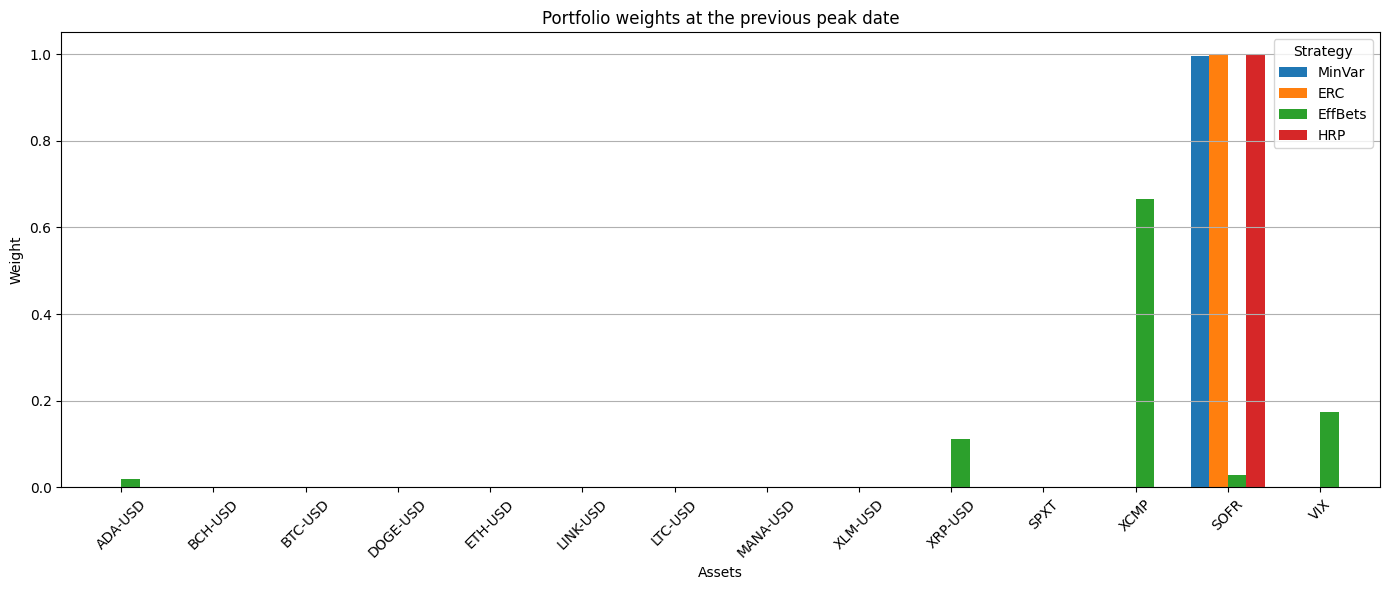

In [39]:
# Séries de poids pour chaque méthode 
mv_weights = pd.Series(MVP_weights_PP, index=cov_PP.columns, name='MinVar')
erc_weights = pd.Series(ERC_weights_PP, index=cov_PP.columns, name='ERC')
enb_weights = pd.Series(ENB_weights_PP, index=cov_PP.columns, name='EffBets')
hrp_weights = pd.Series(HRP_weights_PP, index=cov_PP.columns, name='HRP')

# Combine all into one DataFrame
weights_df = pd.concat([mv_weights, erc_weights, enb_weights, hrp_weights], axis=1)

# Plot grouped bar chart
weights_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Portfolio weights at the previous peak date")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Strategy", loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

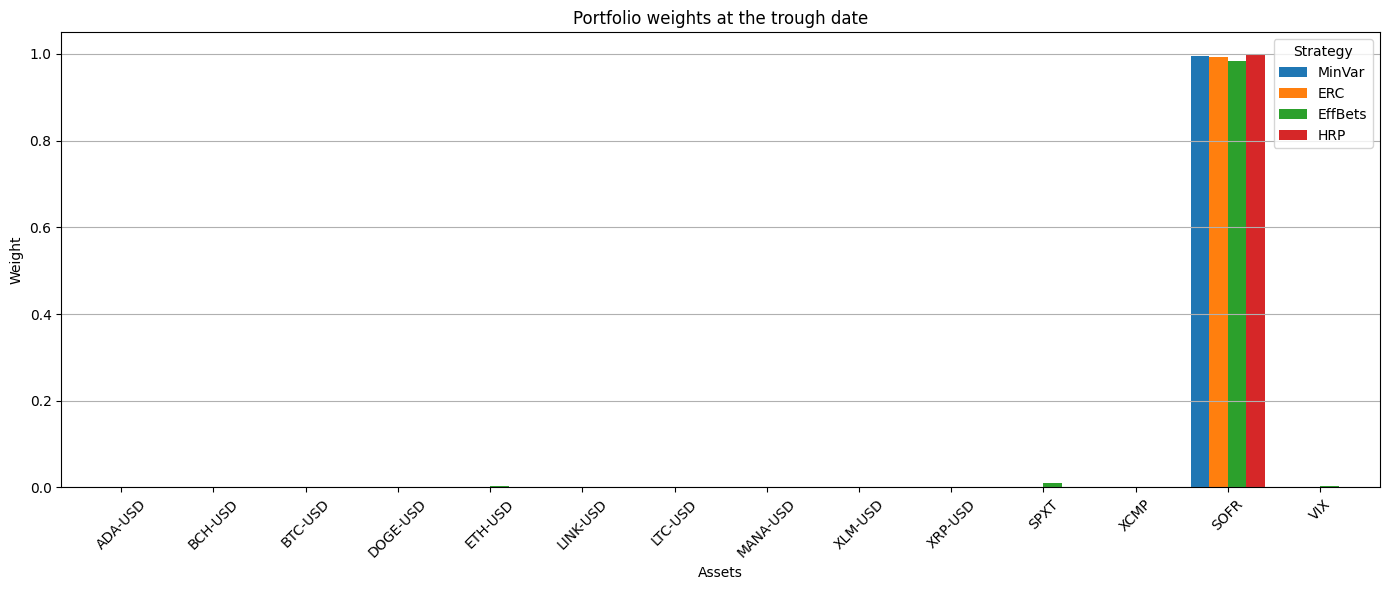

In [40]:
# Séries de poids pour chaque méthode 
mv_weights = pd.Series(MVP_weights_Tr, index=cov_PP.columns, name='MinVar')
erc_weights = pd.Series(ERC_weights_Tr, index=cov_PP.columns, name='ERC')
enb_weights = pd.Series(ENB_weights_Tr, index=cov_PP.columns, name='EffBets')
hrp_weights = pd.Series(HRP_weights_Tr, index=cov_PP.columns, name='HRP')

# Combine all into one DataFrame
weights_df = pd.concat([mv_weights, erc_weights, enb_weights, hrp_weights], axis=1)

# Plot grouped bar chart
weights_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Portfolio weights at the trough date")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Strategy", loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

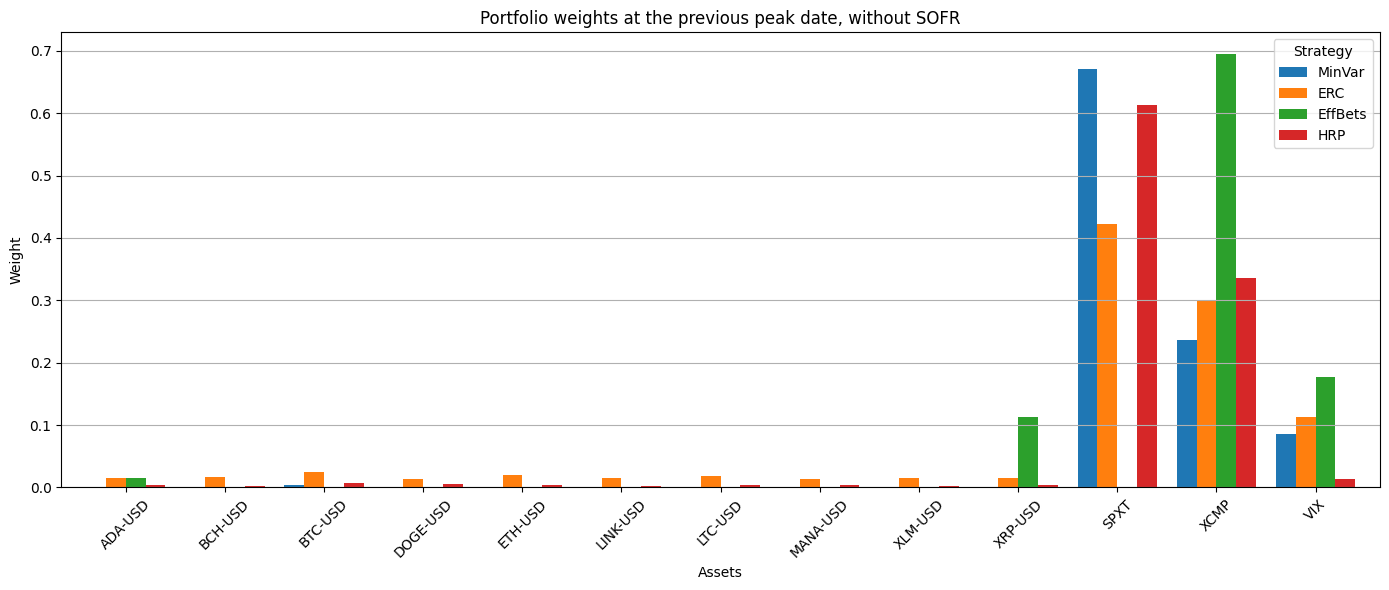

In [41]:
# Séries de poids pour chaque méthode (à adapter avec tes propres variables si besoin)
mv_weights = pd.Series(MVP_weights_PP_sofr, index=cov_PP_sofr.columns, name='MinVar')
erc_weights = pd.Series(ERC_weights_PP_sofr, index=cov_PP_sofr.columns, name='ERC')
enb_weights = pd.Series(ENB_weights_PP_sofr, index=cov_PP_sofr.columns, name='EffBets')
hrp_weights = pd.Series(HRP_weights_PP_sofr, index=cov_PP_sofr.columns, name='HRP')

# Combine all into one DataFrame
weights_df = pd.concat([mv_weights, erc_weights, enb_weights, hrp_weights], axis=1)

# Plot grouped bar chart
weights_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Portfolio weights at the previous peak date, without SOFR")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Strategy", loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

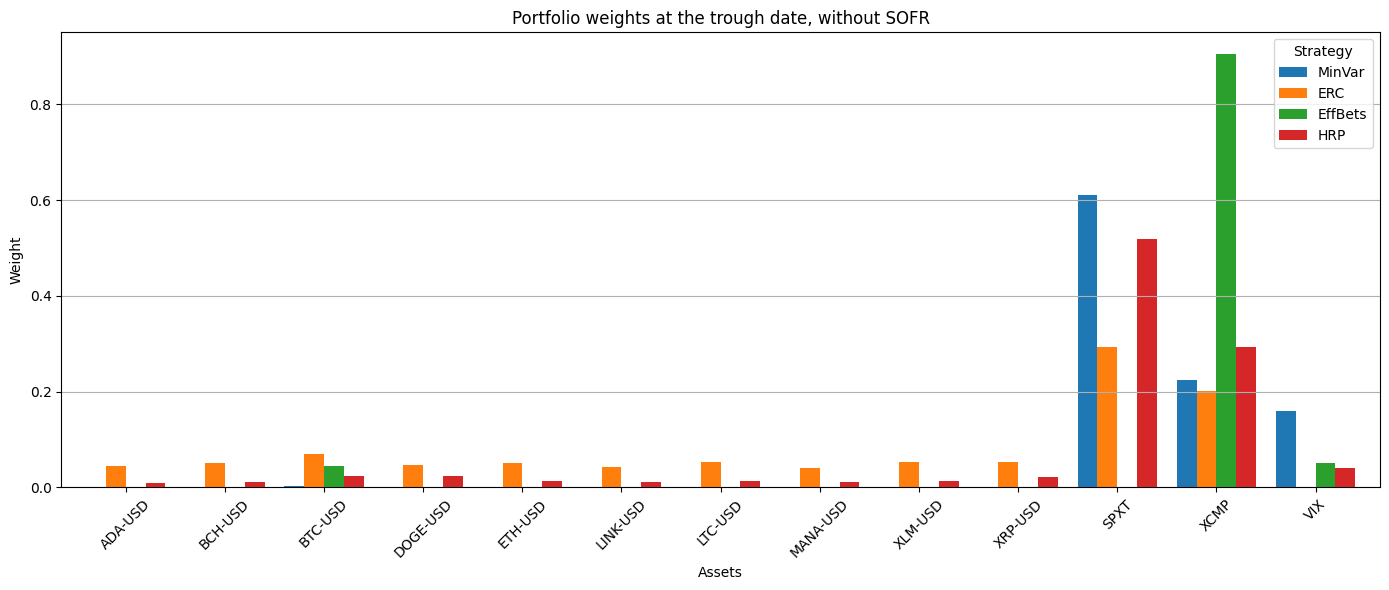

In [42]:
# Séries de poids pour chaque méthode (à adapter avec tes propres variables si besoin)
mv_weights = pd.Series(MVP_weights_Tr_sofr, index=cov_PP_sofr.columns, name='MinVar')
erc_weights = pd.Series(ERC_weights_Tr_sofr, index=cov_PP_sofr.columns, name='ERC')
enb_weights = pd.Series(ENB_weights_Tr_sofr, index=cov_PP_sofr.columns, name='EffBets')
hrp_weights = pd.Series(HRP_weights_Tr_sofr, index=cov_PP_sofr.columns, name='HRP')

# Combine all into one DataFrame
weights_df = pd.concat([mv_weights, erc_weights, enb_weights, hrp_weights], axis=1)

# Plot grouped bar chart
weights_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Portfolio weights at the trough date, without SOFR")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Strategy", loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

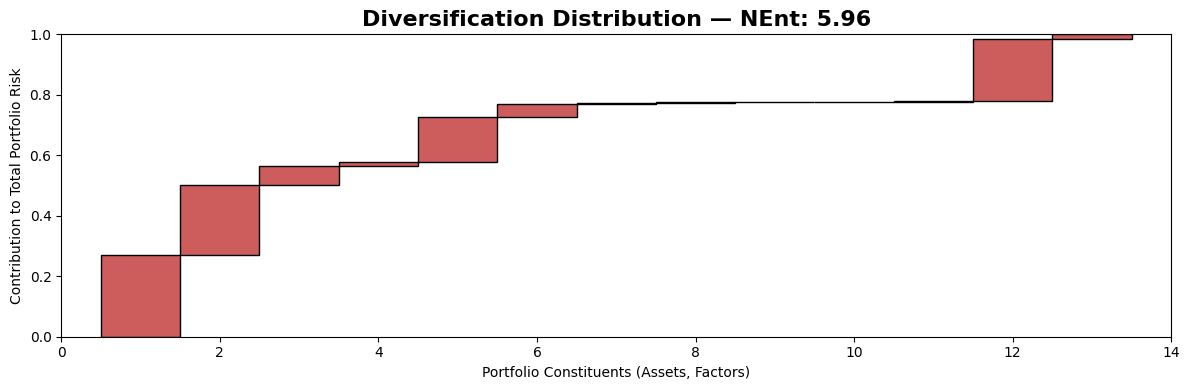

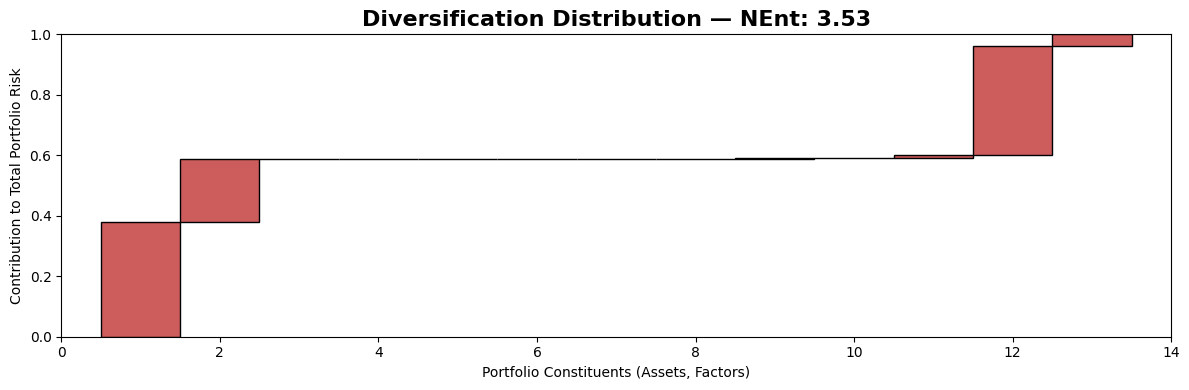

In [43]:
# PP date, without SOFR
plot_diversification_distribution(ENB_weights_PP_sofr,cov_PP_clean_sofr,13)
# Tr date, without SOFR
plot_diversification_distribution(ENB_weights_Tr_sofr,cov_Tr_clean_sofr,13)

Now we do a quick parenthesis to look at what happens if we have cryptos only. This was not part of the assignment, but we are doing it out of personal curiosity!

In [44]:
rets_sans_crypto = rets.drop(columns=["SOFR","VIX","SPXT","XCMP"])

datePP = pd.Timestamp('2021-09-11')
dateTr = pd.Timestamp('2022-11-21')
window = 252  # days in window

# extract rolling windows ending on each date
rets_PP_crypto = rets_sans_crypto.loc[:datePP].iloc[-window:]
rets_Tr_crypto = rets_sans_crypto.loc[:dateTr].iloc[-window:]

# compute sample covariance matrices
cov_PP_crypto = rets_PP_crypto.cov()
cov_Tr_crypto = rets_Tr_crypto.cov()

cov_PP_clean_crypto = clipped(rets_PP_crypto)
cov_Tr_clean_crypto = clipped(rets_Tr_crypto)

MVP_weights_PP_crypto = min_variance_portfolio(cov_PP_clean_crypto)
MVP_weights_Tr_crypto = min_variance_portfolio(cov_Tr_clean_crypto)
ERC_weights_PP_crypto = equal_risk_contribution(cov_PP_clean_crypto)
ERC_weights_Tr_crypto = equal_risk_contribution(cov_Tr_clean_crypto)
ENB_weights_PP_crypto = max_effective_bets_portfolio(cov_PP_clean_crypto)
ENB_weights_Tr_crypto = max_effective_bets_portfolio(cov_Tr_clean_crypto)
HRP_weights_PP_crypto = hierarchical_risk_parity(cov_PP_clean_crypto)
HRP_weights_Tr_crypto = hierarchical_risk_parity(cov_Tr_clean_crypto)

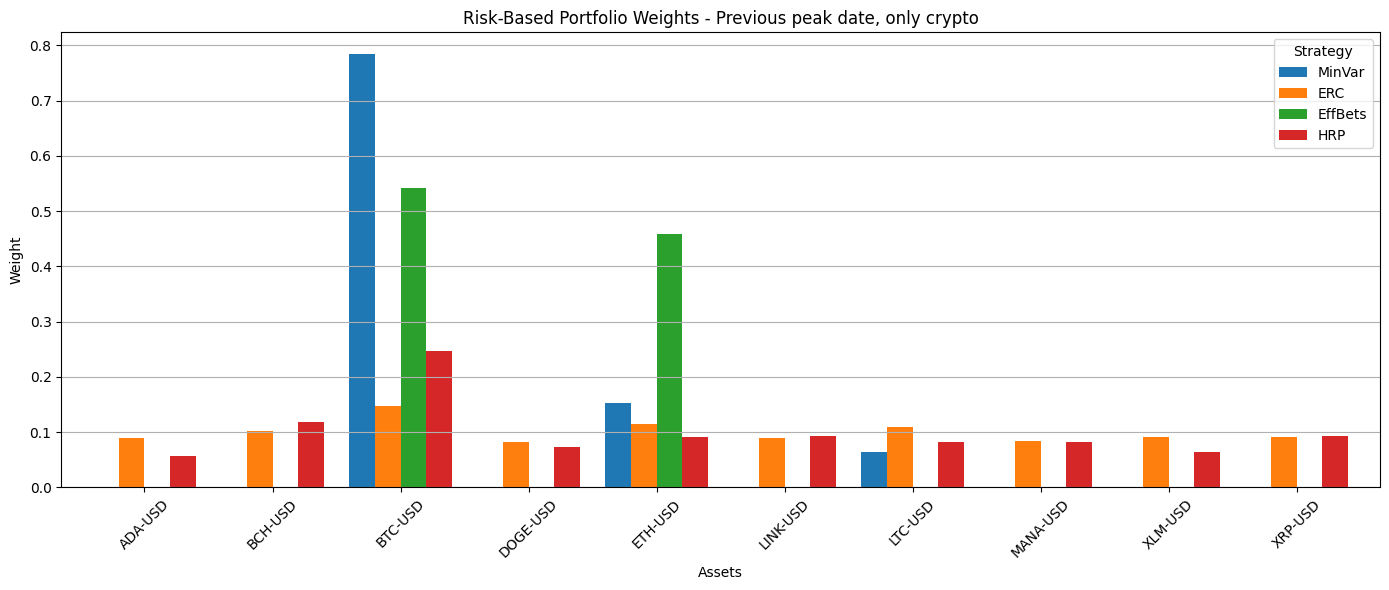

In [45]:
# Séries de poids pour chaque méthode (à adapter avec tes propres variables si besoin)
mv_weights = pd.Series(MVP_weights_PP_crypto, index=cov_PP_crypto.columns, name='MinVar')
erc_weights = pd.Series(ERC_weights_PP_crypto, index=cov_PP_crypto.columns, name='ERC')
enb_weights = pd.Series(ENB_weights_PP_crypto, index=cov_PP_crypto.columns, name='EffBets')
hrp_weights = pd.Series(HRP_weights_PP_crypto, index=cov_PP_crypto.columns, name='HRP')

# Combine all into one DataFrame
weights_df = pd.concat([mv_weights, erc_weights, enb_weights, hrp_weights], axis=1)

# Plot grouped bar chart
weights_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Risk-Based Portfolio Weights - Previous peak date, only crypto")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Strategy", loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

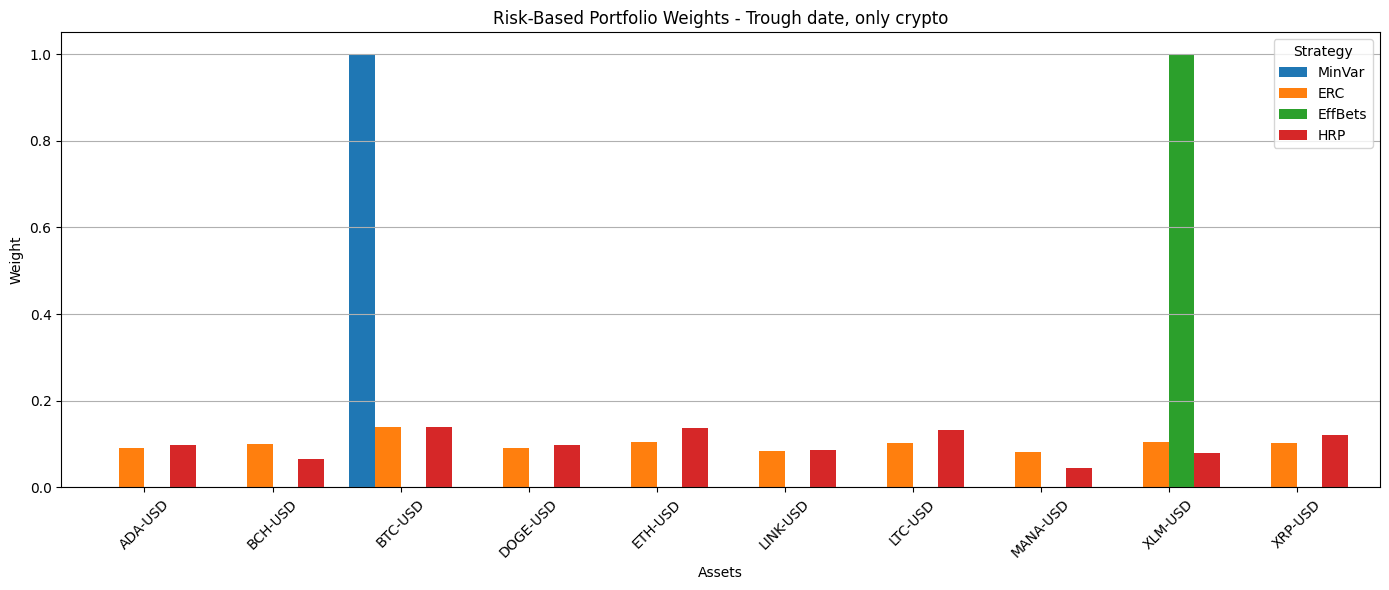

In [46]:
# Séries de poids pour chaque méthode 
mv_weights = pd.Series(MVP_weights_Tr_crypto, index=cov_PP_crypto.columns, name='MinVar')
erc_weights = pd.Series(ERC_weights_Tr_crypto, index=cov_PP_crypto.columns, name='ERC')
enb_weights = pd.Series(ENB_weights_Tr_crypto, index=cov_PP_crypto.columns, name='EffBets')
hrp_weights = pd.Series(HRP_weights_Tr_crypto, index=cov_PP_crypto.columns, name='HRP')

# Combine all into one DataFrame
weights_df = pd.concat([mv_weights, erc_weights, enb_weights, hrp_weights], axis=1)

# Plot grouped bar chart
weights_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Risk-Based Portfolio Weights - Trough date, only crypto")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.xticks(rotation=45)
plt.legend(title="Strategy", loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()